## [7] Amazon Fine Food Reviews Analysis

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

Number of reviews: 568,454
Number of users: 256,059
Number of products: 74,258
Timespan: Oct 1999 - Oct 2012
Number of Attributes/Columns in data: 10

Attribute Information:

    Id
    ProductId - unique identifier for the product
    UserId - unqiue identifier for the user
    ProfileName
    HelpfulnessNumerator - number of users who found the review helpful
    HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
    Score - rating between 1 and 5
    Time - timestamp for the review
    Summary - brief summary of the review
    Text - text of the review

Objective:

Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).


[Q] How to determine if a review is positive or negative?

[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.
[7.1] Loading the data

The dataset is available in two forms

    .csv file
    SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".


## [7.1] Loading the data

The dataset is available in two forms

    .csv file
    SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".


In [ ]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer



# using the SQLite Table to read data.
con = sqlite3.connect('C:/Users/IBM_ADMIN/Desktop/appliedai/Datasets/amazon-fine-food-reviews/database.sqlite') 



#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con) 




# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [3]:
filtered_data.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
filtered_data.shape

(525814, 10)

## Exploratory Data Analysis

### [7.1.2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data. Following is an example:


In [5]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that

ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)

ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.


In [6]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [7]:
sorted_data.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc..."
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...


In [8]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

Original data has 525814 rows. Sized down to 364173 after de-duplication it means 31% of the original data were duplicates.

#### Observation:-
It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [9]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [10]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [11]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

# 7.2.3 Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

    1)Begin by removing the html tags.
    2)Remove any punctuations or limited set of special characters like , or . or # etc.
    3)Check if the word is made up of english letters and is not alpha-numeric
    4)Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
    5)Convert the word to lowercase
    6)Remove Stopwords
    7)Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)

After which we collect the words used to describe positive and negative reviews


In [12]:
import re
# find sentences containing HTML tags
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;  

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [13]:
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

In [14]:
def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

In [15]:
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned


In [16]:
print(stop)
print('************************************')
print(sno.stem('tasty'))# find sentences containing HTML tags 

{'ve', 'yourselves', 'it', 'have', 'of', 'about', 'is', 'and', 'i', 'during', 'shouldn', 's', 'themselves', 'until', 'so', 'd', 'll', 'are', 'the', 'can', 'further', 'when', 'wasn', 'its', 'needn', 'with', 'where', 'below', 'why', 'from', 'some', 'was', 'that', 'who', 'doing', 'then', 'm', 'am', 'myself', 'he', "wouldn't", 'ain', 'which', 'how', 'out', 'over', 're', 'haven', 'o', 'in', 'his', 'those', 'after', "shan't", 'while', 'on', 'should', 'down', 'once', 'him', 'y', 'if', 'don', 'for', 'under', 'herself', "doesn't", "hadn't", "it's", 'nor', 'because', 'again', 'theirs', 'other', 'to', "hasn't", "shouldn't", "you'd", 'himself', 'being', 'or', "won't", 'hers', 'very', 'isn', 'above', 'both', 'be', "mustn't", 'what', 'having', 'now', 'no', 'ourselves', "aren't", 'any', 'same', 'shan', 'your', 'than', 'their', "don't", 'this', 'does', 'these', 'all', 'more', "you'll", 'between', 'as', 'just', "that'll", 'yours', 'there', "needn't", 'has', 'most', 'before', "haven't", 'my', "you're", 

In [17]:
final_f=final[0:150000:]

In [18]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final_f['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final_f['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final_f['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [19]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [20]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

#mpl.rcParams['figure.figsize']=(8.0,6.0)    #(6.0,4.0)
plt.rcParams['font.size']=12                #10 
plt.rcParams['savefig.dpi']=100             #72 
plt.rcParams['figure.subplot.bottom']=.1 


def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(8, 8))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

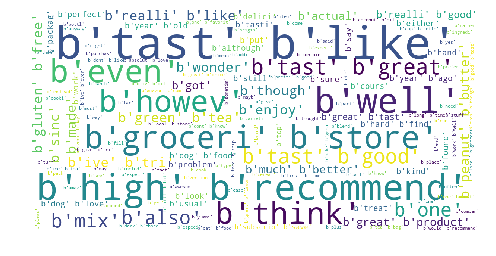

In [21]:
show_wordcloud(all_positive_words)

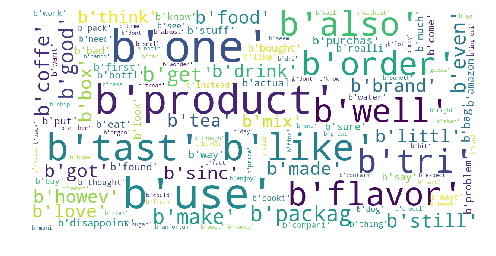

In [22]:
show_wordcloud(all_negative_words)

In [23]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 

In [24]:
final.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'fun way children learn month year learn poem...


In [25]:
final.head(3) #below the processed review can be seen in the CleanedText Column 


# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn, flavor=None, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

# [7.2.2] Bag of Words (BoW)

In [26]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(final['Text'].values)

In [27]:
type(final_counts)

scipy.sparse.csr.csr_matrix

In [28]:
final_counts.shape

(364171, 115281)

# [7.2.4] Bi-Grams and n-Grams.

### Motivation

Now that we have our list of words describing positive and negative reviews lets analyse them.

We begin analysis by getting the frequency distribution of the words as shown below

In [29]:
freq_dist_positive=nltk.FreqDist(all_positive_words)
freq_dist_negative=nltk.FreqDist(all_negative_words)
print("Most Common Positive Words : ",freq_dist_positive.most_common(20))
print("Most Common Negative Words : ",freq_dist_negative.most_common(20))

Most Common Positive Words :  [(b'like', 139429), (b'tast', 129047), (b'good', 112766), (b'flavor', 109624), (b'love', 107357), (b'use', 103888), (b'great', 103870), (b'one', 96726), (b'product', 91033), (b'tri', 86791), (b'tea', 83888), (b'coffe', 78814), (b'make', 75107), (b'get', 72125), (b'food', 64802), (b'would', 55568), (b'time', 55264), (b'buy', 54198), (b'realli', 52715), (b'eat', 52004)]
Most Common Negative Words :  [(b'tast', 34585), (b'like', 32330), (b'product', 28218), (b'one', 20569), (b'flavor', 19575), (b'would', 17972), (b'tri', 17753), (b'use', 15302), (b'good', 15041), (b'coffe', 14716), (b'get', 13786), (b'buy', 13752), (b'order', 12871), (b'food', 12754), (b'dont', 11877), (b'tea', 11665), (b'even', 11085), (b'box', 10844), (b'amazon', 10073), (b'make', 9840)]


__Observation:-__ From the above it can be seen that the most common positive and the negative words overlap for eg. 'like' could be used as 'not like' etc.
So, it is a good idea to consider pairs of consequent words (bi-grams) or q sequnce of n consecutive words (n-grams)

The same has been observed from the word clouds above

In [30]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
count_vect = CountVectorizer(ngram_range=(1,2) ) #in scikit-learn
final_bigram_counts = count_vect.fit_transform(final['Text'].values)

In [31]:
final_bigram_counts

<364171x2910192 sparse matrix of type '<class 'numpy.int64'>'
	with 45049660 stored elements in Compressed Sparse Row format>

In [32]:
final_bigram_counts.shape

(364171, 2910192)

# [7.2.5] TF-IDF

In [33]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(final['Text'].values)

In [42]:
final_tf_idf.get_shape()

(364171, 2910192)

In [35]:
features = tf_idf_vect.get_feature_names()
len(features)

2910192

In [36]:
features[200000:200010]

['around eat',
 'around eating',
 'around ebay',
 'around edge',
 'around edges',
 'around effects',
 'around eight',
 'around either',
 'around elsewhere',
 'around empty']

In [37]:
# covnert a row in saprsematrix to a numpy array
print(final_tf_idf[3,:].toarray()[0]) 

[ 0.  0.  0. ...,  0.  0.  0.]


In [38]:
# source: https://buhrmann.github.io/tfidf-analysis.html
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

top_tfidf = top_tfidf_feats(final_tf_idf[1,:].toarray()[0],features,25)

In [39]:
top_tfidf

,feature,tfidf
0,sendak books,0.173437
1,rosie movie,0.173437
2,paperbacks seem,0.173437
3,cover version,0.173437
4,these sendak,0.173437
5,the paperbacks,0.173437
6,pages open,0.173437
7,really rosie,0.168074
8,incorporates them,0.168074
9,paperbacks,0.168074


# [7.2.6] Word2Vec

In [ ]:
# Using Google News Word2Vectors
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

C:\Users\IBM_ADMIN\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [ ]:
# Train your own Word2Vec model using your own text corpus
import gensim
i=0
list_of_sent=[]
for sent in final['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)
    